# Sepsis Classification

In [6]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

# Data Splitting and Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Model evaluation
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

# Saving Model
from joblib import dump
import pickle

# Misc
import shap
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier

In [26]:
sns.set()

In [8]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [9]:
train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


ID: Unique number to represent patient ID

PRG: Plasma glucose

PL: Blood Work Result-1 (mu U/ml)

PR: Blood Pressure (mm Hg)

SK: Blood Work Result-2 (mm)

TS: Blood Work Result-3 (mu U/ml)

M11: Body mass index (weight in kg/(height in m)^2

BD2: Blood Work Result-4 (mu U/ml)

Age(: patients age (years)

Insurance: If a patient holds a valid insurance card

Sepsis: Positive if a patient in ICU will develop a sepsis , and Negative otherwise

## EDA

In [12]:
#Check dataset dimension 
print("Number of rows in the training dataset:", train.shape[0])
print("Number of columns in the training dataset:", train.shape[1])

Number of rows in the training dataset: 599
Number of columns in the training dataset: 11


In [14]:
#Check dataset dimension 
print("Number of rows in the test dataset:", test.shape[0])
print("Number of columns in the test dataset:", test.shape[1])

Number of rows in the test dataset: 169
Number of columns in the test dataset: 10


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


### Numerical variables

In [16]:
train.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [17]:
df = train.copy()

### Univariate Analysis

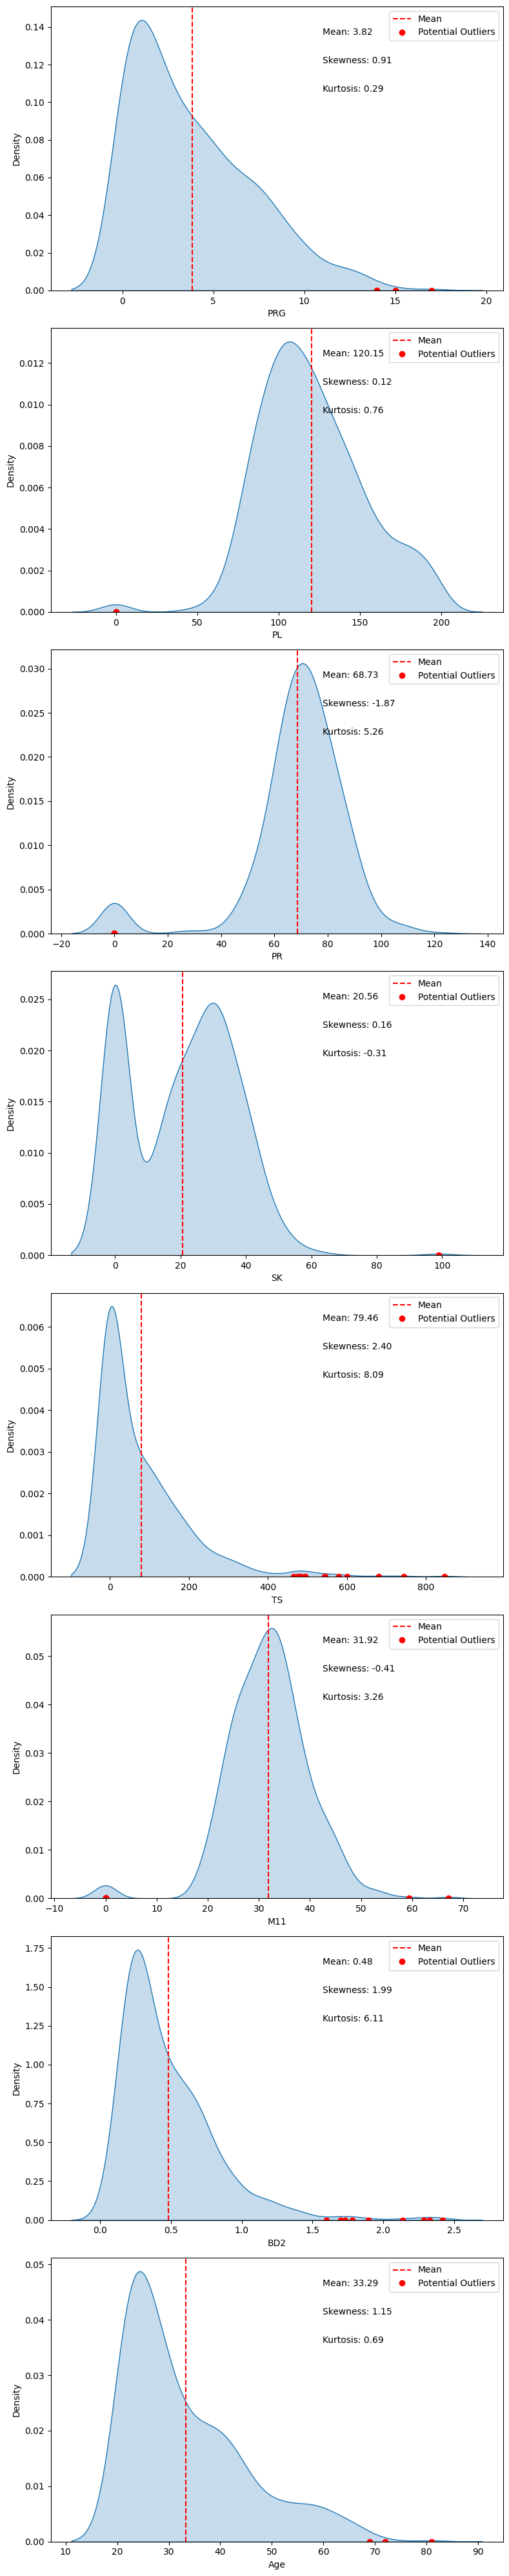

In [19]:
columns_to_plot = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

# Plot KDEs(kernel density estimation) for all columns
fig, axes = plt.subplots(nrows=len(columns_to_plot), figsize=(8, 40))
for i, col in enumerate(columns_to_plot):
    sns.kdeplot(data=df, x=col, ax=axes[i], fill=True)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    
    # Calculate mean, skewness, and kurtosis
    mean_val = df[col].mean()
    skewness_val = df[col].skew()
    kurtosis_val = df[col].kurtosis()
    
    # Mean , skewness, and kurtosis annotations
    axes[i].text(0.6, 0.9, f'Mean: {mean_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.8, f'Skewness: {skewness_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.7, f'Kurtosis: {kurtosis_val:.2f}', transform=axes[i].transAxes)
    
    # Mean line
    axes[i].axvline(mean_val, color='red', linestyle='--', label='Mean')
    
    # Marking outliers
    outliers = df[(df[col] > mean_val + 3 * df[col].std()) | (df[col] < mean_val - 3 * df[col].std())]
    axes[i].plot(outliers[col], [0] * len(outliers), 'ro', label='Potential Outliers')
    
    axes[i].legend()
    
plt.tight_layout()
plt.show()

KDE plot analyses reveal varying distribution shapes and skewness across variables:

- PRG variable shows a positive skew ais platykurt distributionic, indicating a flatter peak with lighter tails than normal.
- PL variable is approximately symmetric, with a mean of 120.15, and mesokurtic, resembling a normal distribution.
- Blood pressure distribution is negatively skewed with a peaked shape, suggesting possible outliers.
- Blood work result 2 is slightly positively skewed with a flatter shape, indicating fewer outliers.
- TS (blood work result 3) is positively skewed with a peaked shape and heavier tails, suggesting more outliers.
- Body mass index is slightly negatively skewed with a peaked shape and heavier tails, indicating more outliers.
- Another blood work result shows a positive skew with a peaked shape and heavier tails, indicating more outliers and a higher frequency of lower values.
- Age distribution is positively skewed, suggesting a higher frequency of younger individuals with a more uniform spread and fewer outliers.

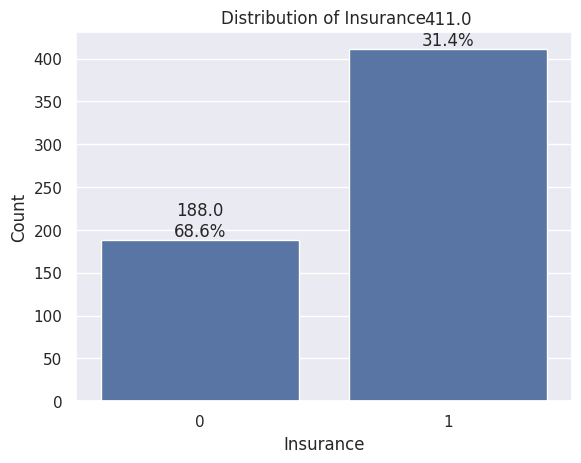

In [27]:
# Count plot for "Insurance"
sns.countplot(data=df, x='Insurance')

# Set labels
plt.xlabel('Insurance')
plt.ylabel('Count')

# Set title
plt.title('Distribution of Insurance')

# Calculate percentage distribution
total = len(df['Insurance'])
percentages = df['Insurance'].value_counts(normalize=True) * 100

# Add data labels and percentage annotations
for p, percentage in zip(plt.gca().patches, percentages):
    count = p.get_height()
    percentage_label = f'{percentage:.1f}%'
    plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
plt.show()

#### Outlier Analysis

Number of outliers in PRG: 4


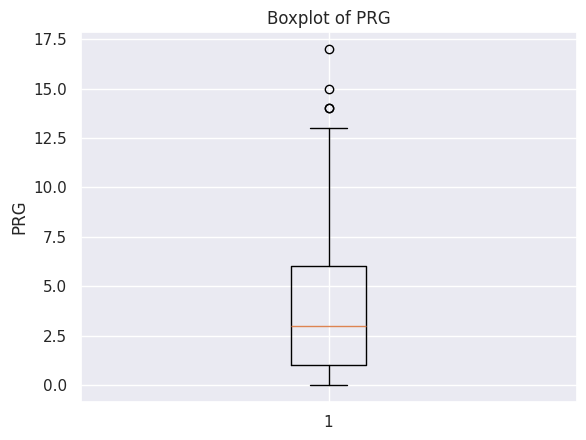

Number of outliers in PL: 0


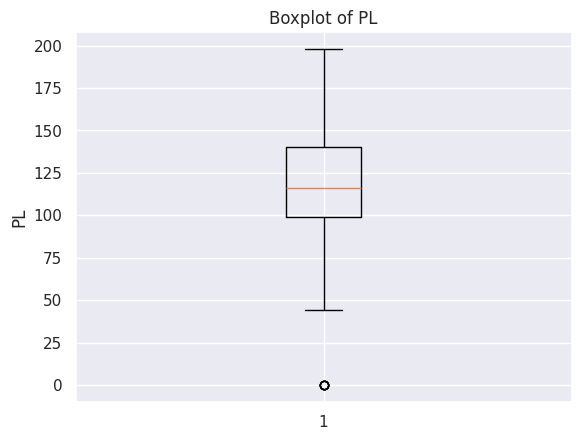

Number of outliers in PR: 6


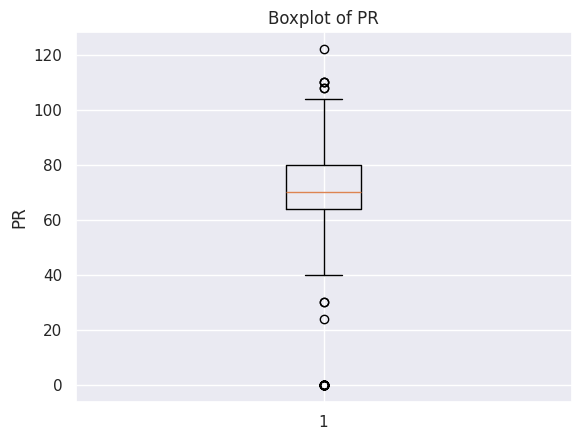

Number of outliers in SK: 1


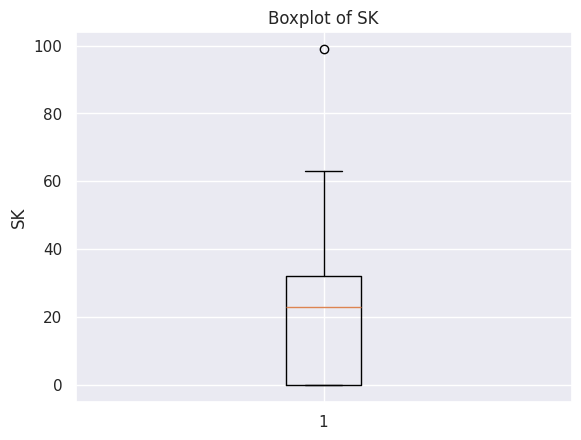

Number of outliers in TS: 28


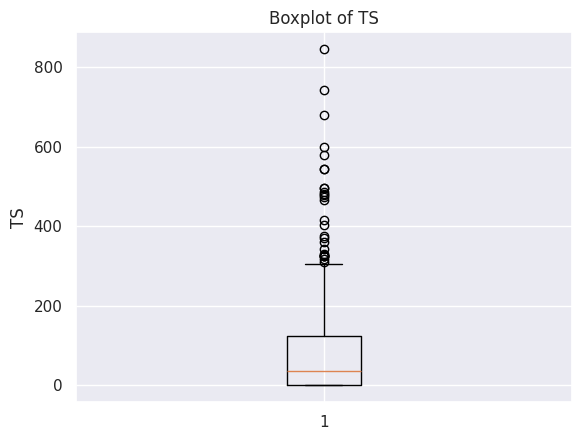

Number of outliers in M11: 7


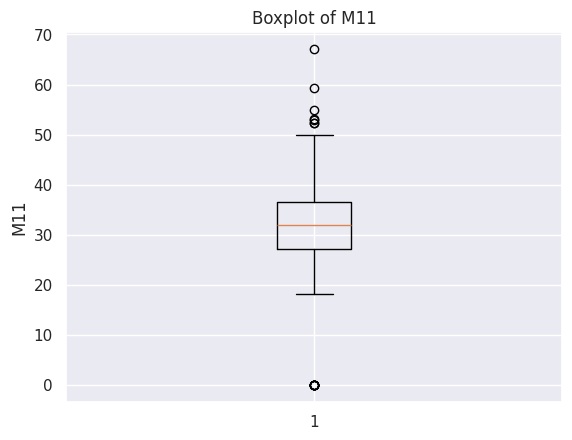

Number of outliers in BD2: 19


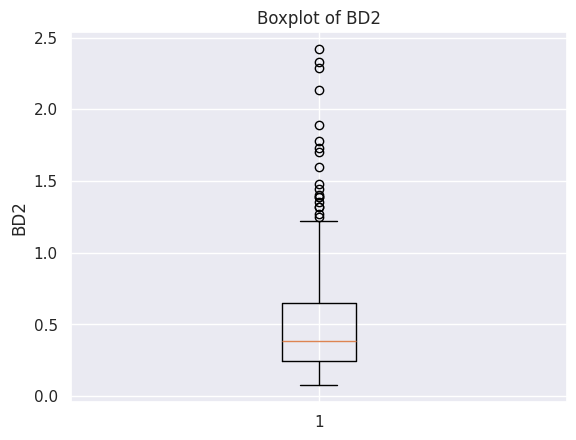

Number of outliers in Age: 12


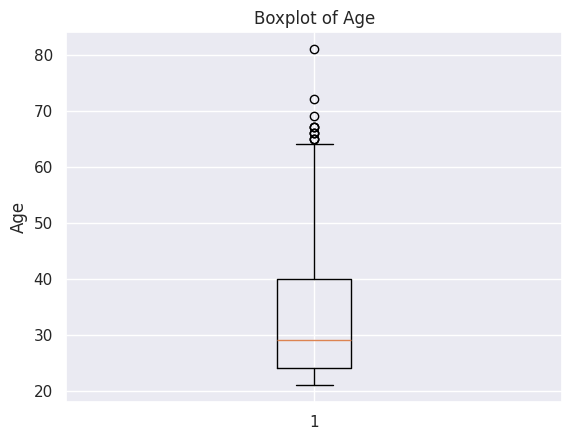

Number of outliers in Insurance: 0


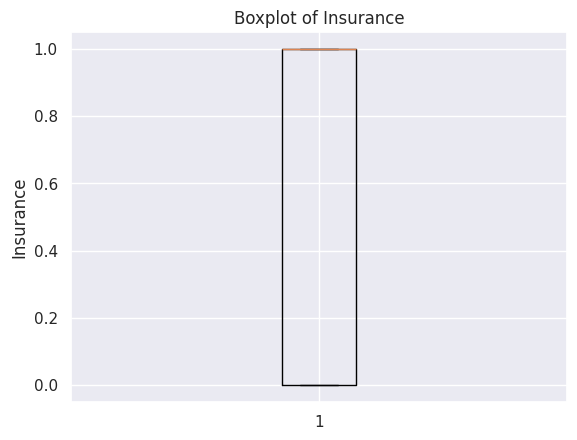

In [28]:
# Select numerical columns
numerical_cols = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']

# Iterate over each numerical column
for col in numerical_cols:
    # Create a box plot
    plt.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    # Get the outliers
    outliers = df[df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))]  # Adjust the outlier threshold if needed

    # Print the number of outliers
    num_outliers = len(outliers)
    print(f"Number of outliers in {col}: {num_outliers}")

    # Show the plot
    plt.show()

### Bivariate Analysis

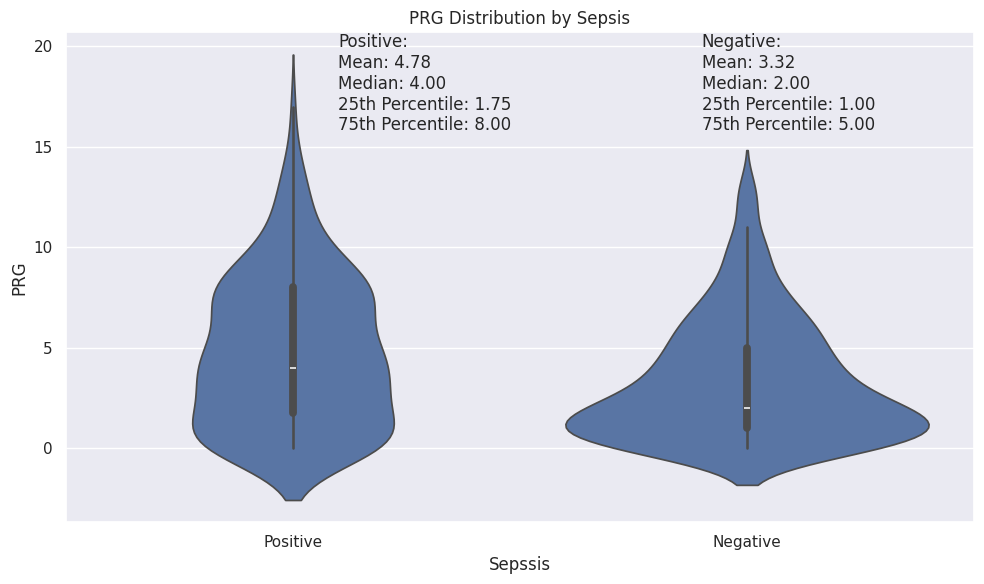

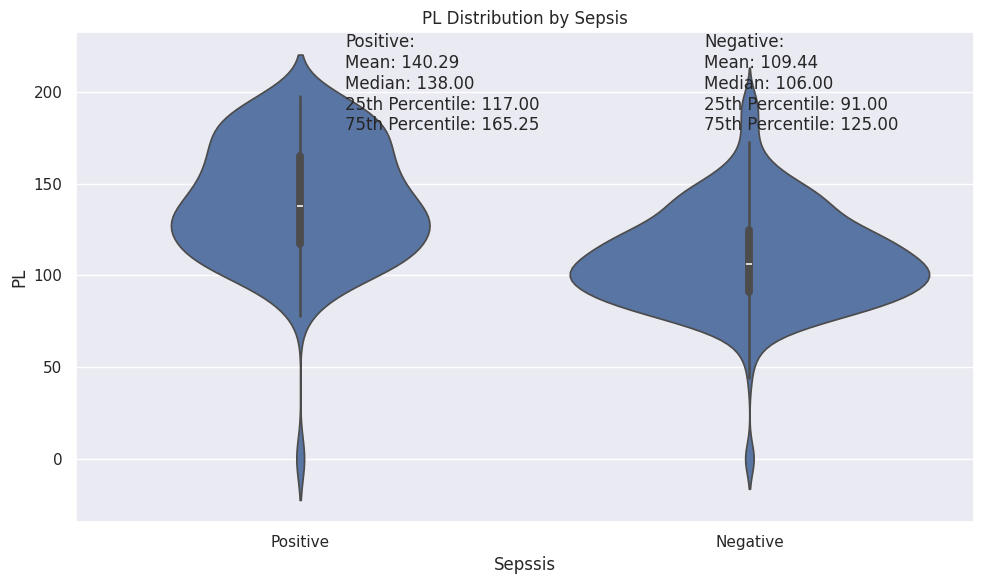

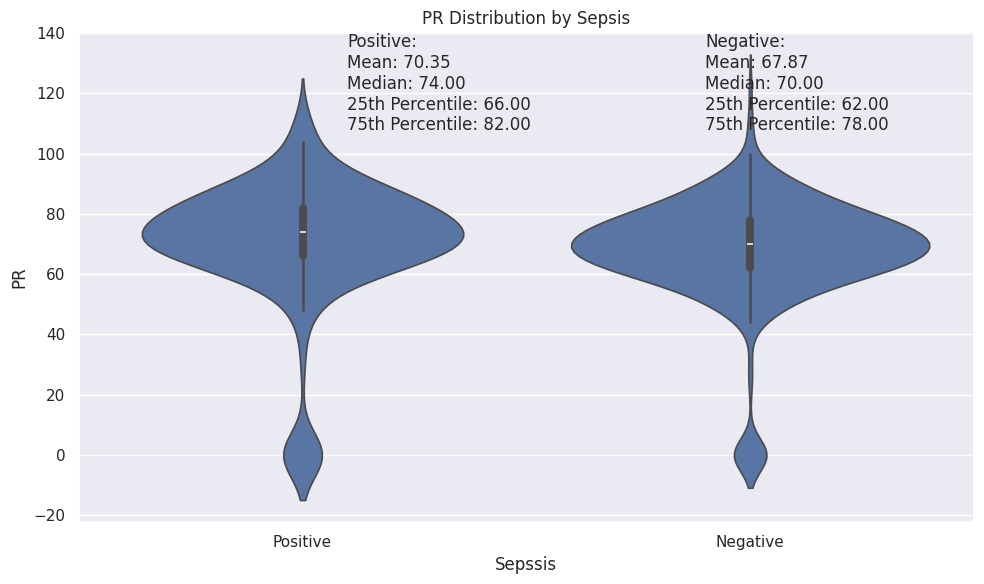

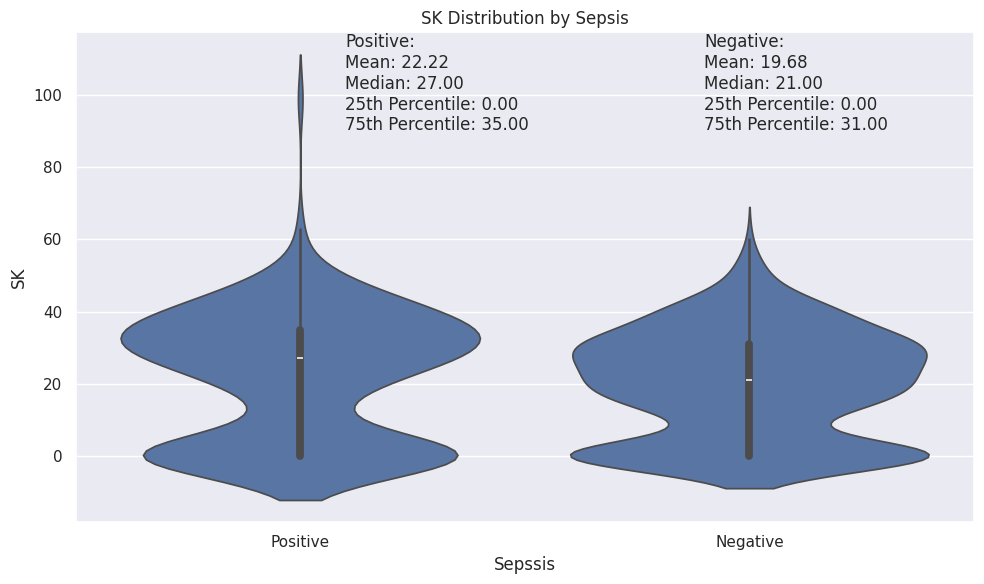

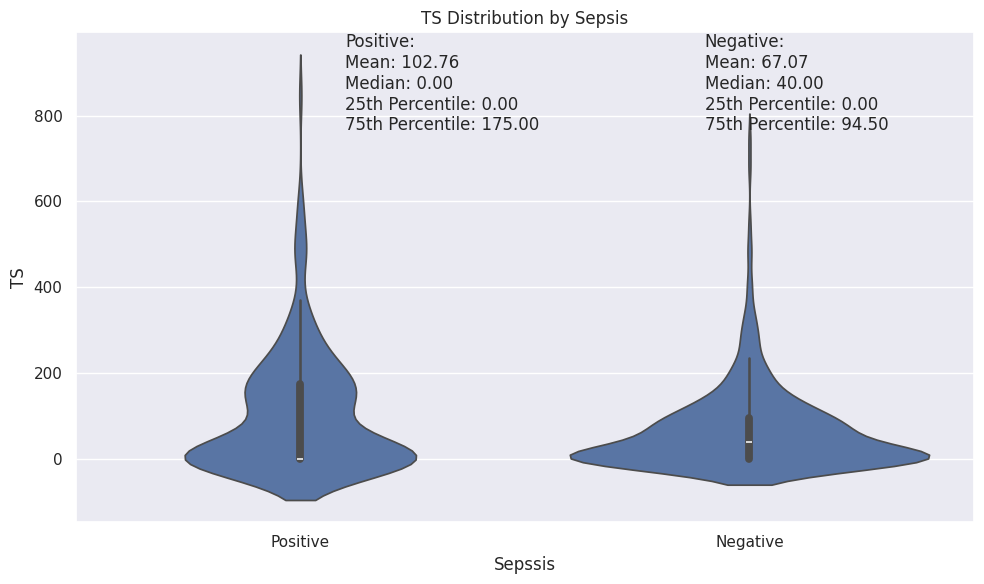

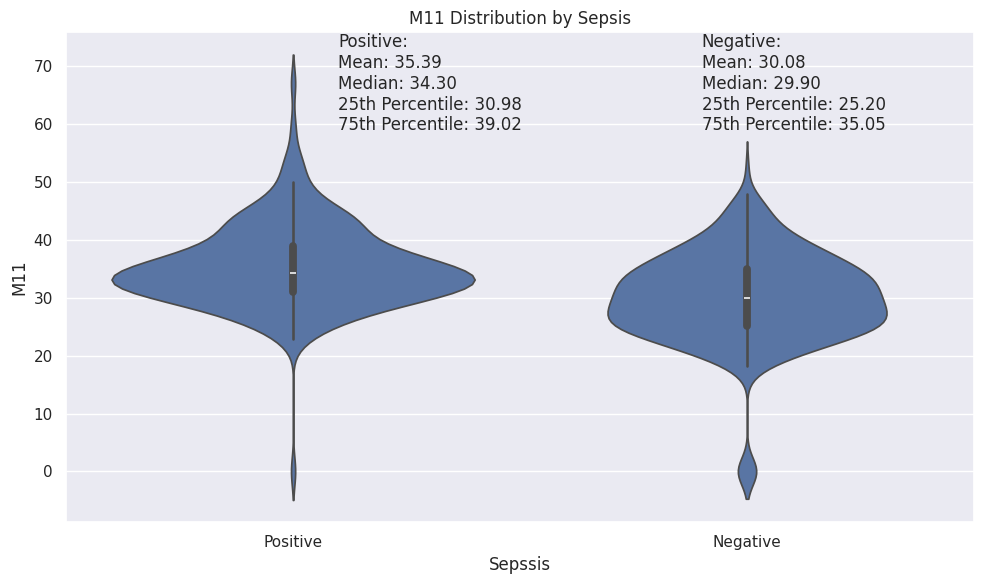

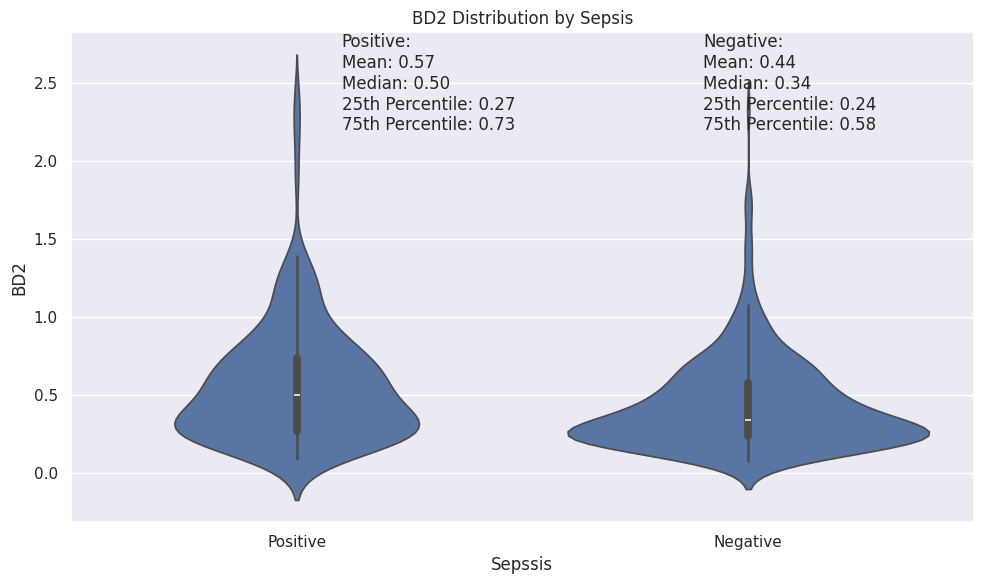

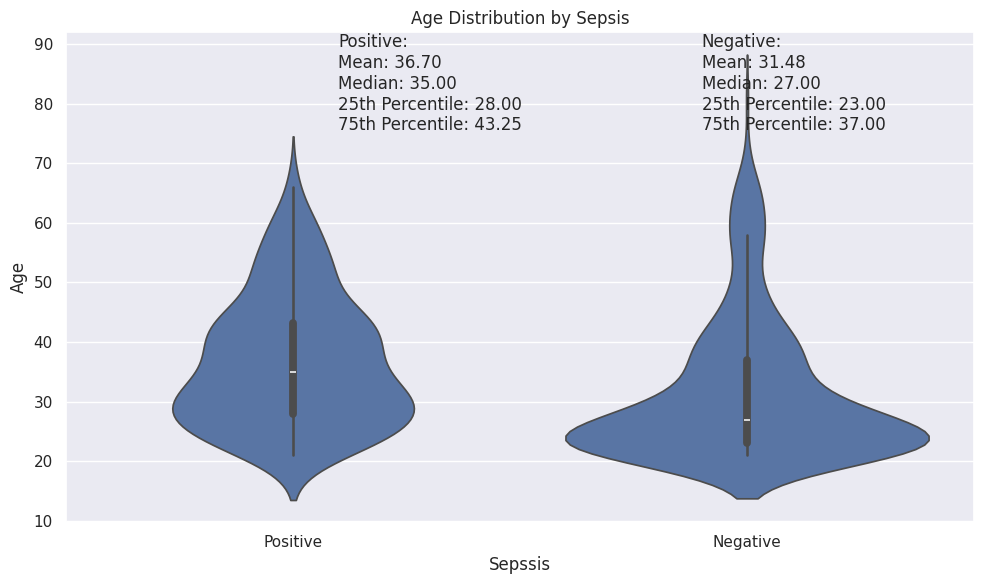

In [34]:
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='Sepssis', y=var)
    plt.xlabel('Sepssis')
    plt.ylabel(var)
    plt.title(f'{var} Distribution by Sepsis')
    
    positive_vals = df[df['Sepssis'] == 'Positive'][var]
    negative_vals = df[df['Sepssis'] == 'Negative'][var]
    stat_dict = {
        'Positive': {
            'Mean': np.mean(positive_vals),
            'Median': np.median(positive_vals),
            '25th Percentile': np.percentile(positive_vals, 25),
            '75th Percentile': np.percentile(positive_vals, 75)
        },
        'Negative': {
            'Mean': np.mean(negative_vals),
            'Median': np.median(negative_vals),
            '25th Percentile': np.percentile(negative_vals, 25),
            '75th Percentile': np.percentile(negative_vals, 75)
        }
    }
    
    plt.text(0.30, 0.8, f"Positive:\nMean: {stat_dict['Positive']['Mean']:.2f}\nMedian: {stat_dict['Positive']['Median']:.2f}\n25th Percentile: {stat_dict['Positive']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Positive']['75th Percentile']:.2f}", transform=plt.gca().transAxes)
    plt.text(0.70, 0.8, f"Negative:\nMean: {stat_dict['Negative']['Mean']:.2f}\nMedian: {stat_dict['Negative']['Median']:.2f}\n25th Percentile: {stat_dict['Negative']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Negative']['75th Percentile']:.2f}", transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

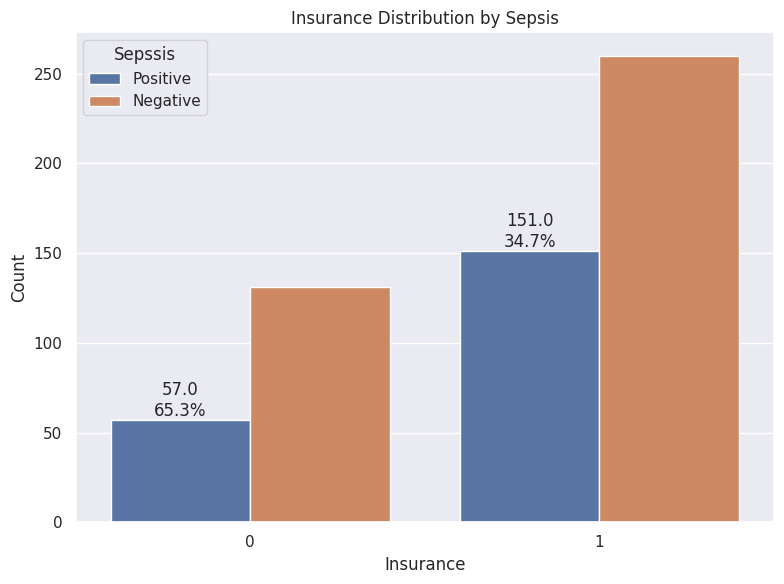

In [33]:
# Categorical Variables - Bar plots
categorical_vars = ['Insurance']
for var in categorical_vars:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=var, hue='Sepssis')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'{var} Distribution by Sepsis')

    # Percentage distribution
    total = len(df['Sepssis'])
    percentages = df['Sepssis'].value_counts(normalize=True) * 100

    for p, percentage in zip(plt.gca().patches, percentages):
        count = p.get_height()
        percentage_label = f'{percentage:.1f}%'
        plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [32]:
df['Sepsis_Encoded'] = df['Sepssis'].map({'Negative': 0, 'Positive': 1})

# Correlation coefficients
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df[numerical_vars + ['Sepsis_Encoded']].corr()

for var in numerical_vars:
    correlation = correlations.loc[var, 'Sepsis_Encoded']
    print(f"Pearson correlation between 'Sepssis_Encoded' and '{var}': {correlation:.2f}")

Pearson correlation between 'Sepssis_Encoded' and 'PRG': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'PL': 0.45
Pearson correlation between 'Sepssis_Encoded' and 'PR': 0.06
Pearson correlation between 'Sepssis_Encoded' and 'SK': 0.08
Pearson correlation between 'Sepssis_Encoded' and 'TS': 0.15
Pearson correlation between 'Sepssis_Encoded' and 'M11': 0.32
Pearson correlation between 'Sepssis_Encoded' and 'BD2': 0.18
Pearson correlation between 'Sepssis_Encoded' and 'Age': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'Insurance': 0.06


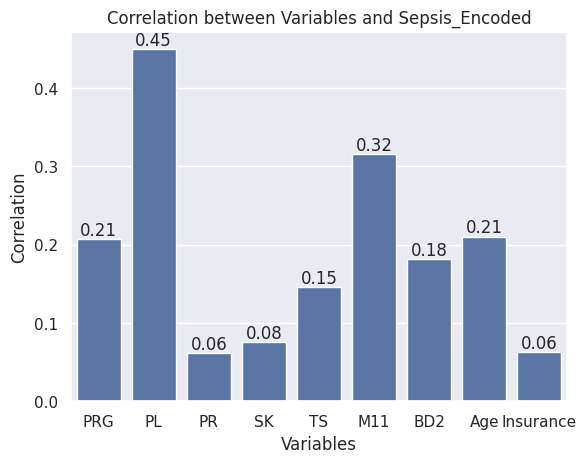

In [36]:
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df[numerical_vars + ['Sepssis_Encoded']].corr()

correlation_values = correlations.loc[numerical_vars, 'Sepssis_Encoded']

sns.barplot(x=numerical_vars, y=correlation_values)

for i, val in enumerate(correlation_values):
    plt.text(i, val, round(val, 2), ha='center', va='bottom')

plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Correlation between Variables and Sepsis_Encoded')

plt.show()

The correlation analysis with 'Sepsis_Encoded' reveals:

- 'PRG' and 'Age' have weak positive correlations (0.21), indicating a slight increase in sepsis likelihood with higher plasma glucose levels and age.
- 'PL' shows a moderate positive correlation (0.45), suggesting a stronger link with sepsis likelihood.
- 'PR', 'SK', and 'Insurance' show very weak positive correlations (0.06, 0.08, 0.06 respectively), implying negligible relationships with sepsis likelihood.
- 'TS' and 'BD2' also have weak positive correlations (0.15, 0.18), suggesting limited associations with sepsis.
- 'M11' (BMI) has a moderate positive correlation (0.32), indicating a more pronounced relationship with sepsis likelihood.

Overall, PL and BMI seem to have stronger positive correlations with sepsis likelihood, while other variables show limited or negligible relationships.

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


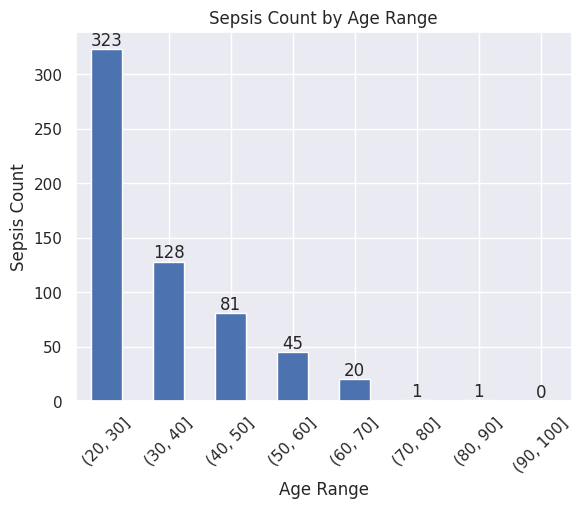

In [38]:
age_ranges = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100])
grouped_data = df.groupby(age_ranges)

count_sepsis_by_age = grouped_data['Sepssis'].count()

ax = count_sepsis_by_age.plot(kind='bar', xlabel='Age Range', ylabel='Sepsis Count', title='Sepsis Count by Age Range')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

The data shows that the age group (20, 30] has the highest number of sepsis cases at 323, but its mean sepsis rate is lower at 0.23 when compared to other age groups. This suggests that despite the high case count, the prevalence of sepsis in this demographic is lower relative to its population size. Larger population numbers in the (20, 30] age group inflate the case count but don't necessarily indicate a higher risk of sepsis within that group. Conversely, older age ranges, despite having fewer cases, may have a higher proportion of sepsis cases relative to their smaller population sizes.

### Multivariate Analysis

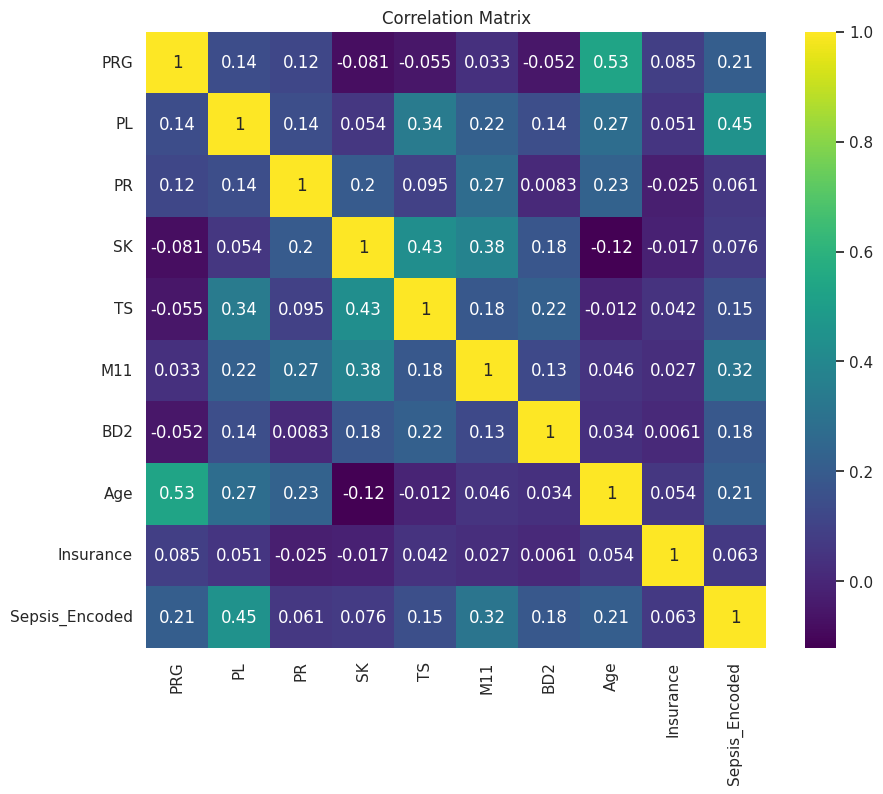

In [39]:
correlations = df[numerical_vars + ['Sepsis_Encoded']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

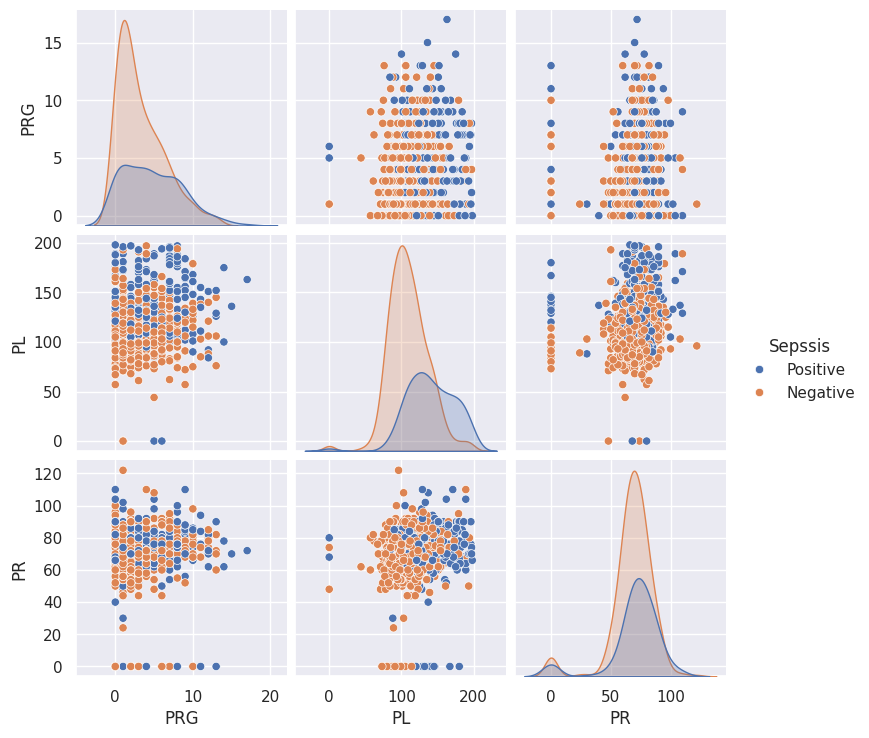

In [40]:
numerical_vars = ['PRG', 'PL', 'PR']
sns.pairplot(data=df, vars=numerical_vars, hue='Sepssis');

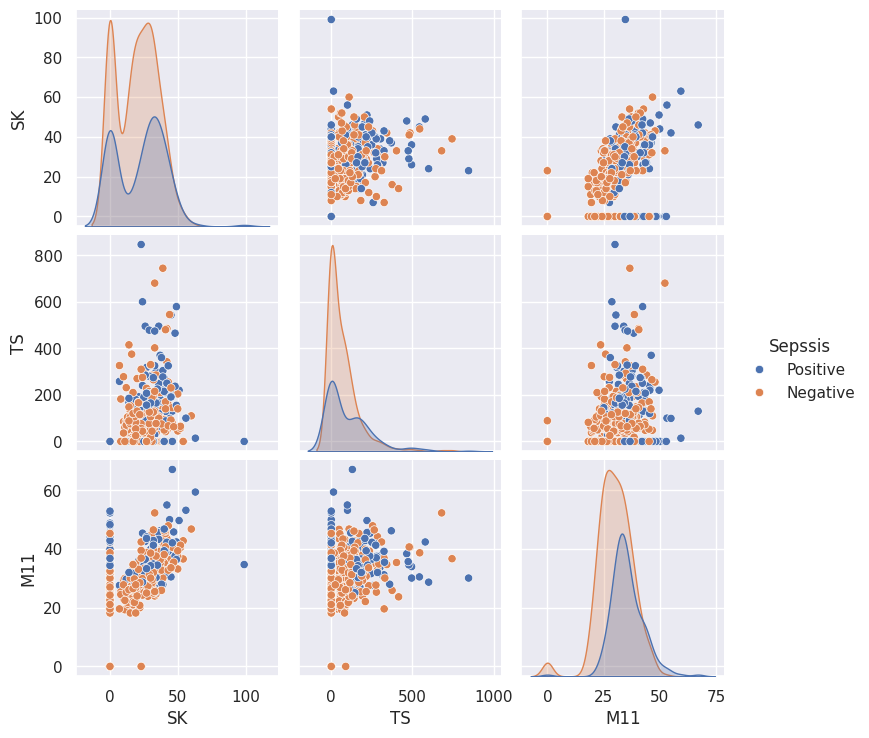

In [41]:
numerical_vars = ['SK', 'TS', 'M11']
sns.pairplot(data=df, vars=numerical_vars, hue='Sepssis');

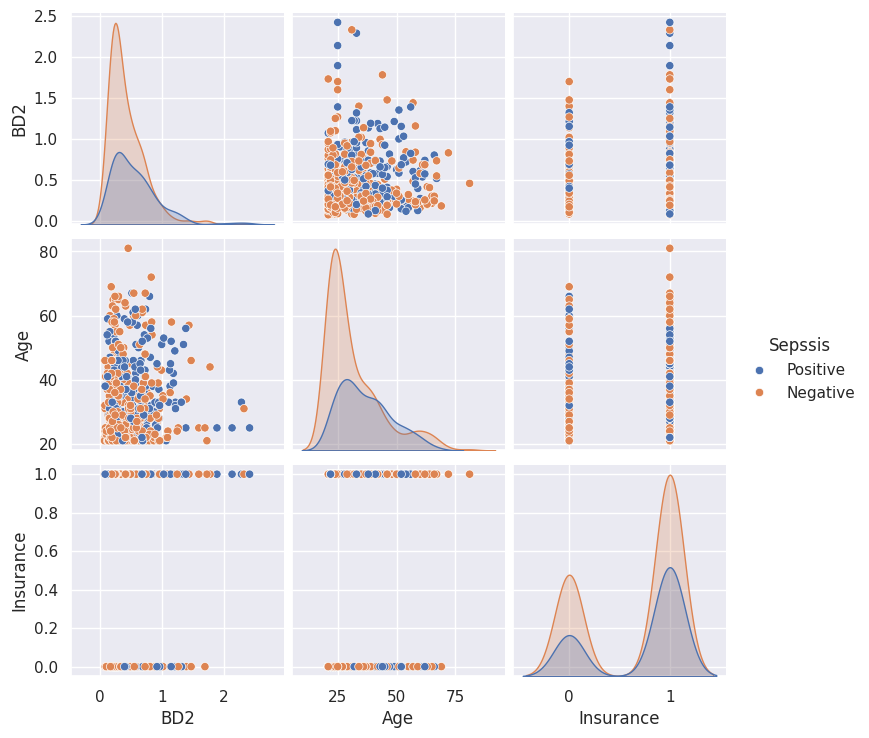

In [42]:
numerical_vars = ['BD2', 'Age', 'Insurance']
sns.pairplot(data=df, vars=numerical_vars, hue='Sepssis');

### Hypothesis Testing